# CNN Skin Cancer Detection

### <font color="brown">Problem statement: </font>

To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

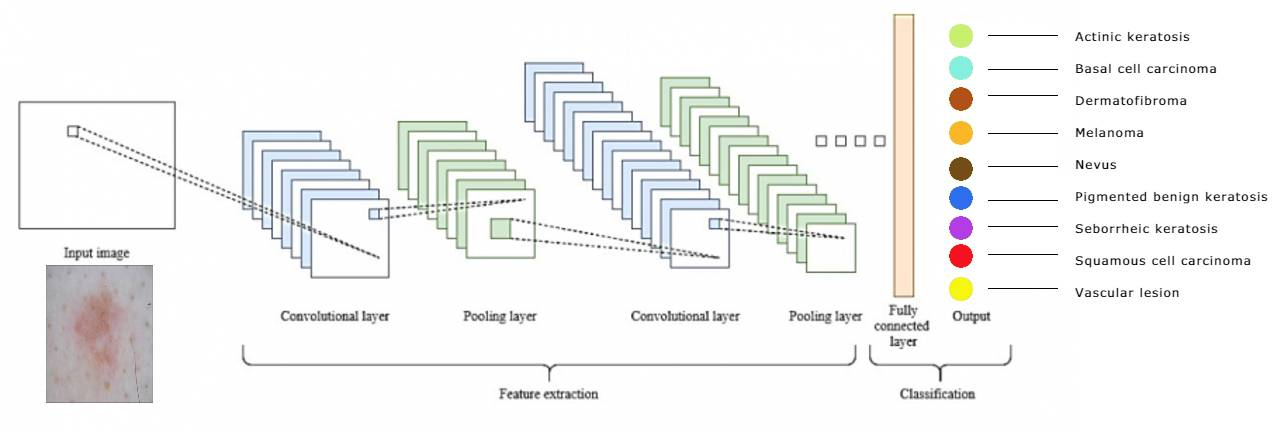

### Importing Skin Cancer Data
#### Take necessary actions to read the data

### Importing all the important libraries

In [ ]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import os
import PIL
from glob import glob
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [ ]:
# Defining the path for train and test images
data_dir_train = pathlib.Path("/content/gdrive/MyDrive/data/Train")
data_dir_test = pathlib.Path('/content/gdrive/MyDrive/data/Test')

In [ ]:
# Let us check the image counts for train and test directory
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [ ]:
# Let us define a batch size of 32 and image width and height of 180 each
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [ ]:
# Let us define train dataset using the parameters seed as 123 and resizing image width and height as defined above
# This is a training subset and 20% images will be used for validation while 80% for training

train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [ ]:
# Let us define validation dataset using the parameters seed as 123 and resizing image width and height as defined above
# This is a validation subset and 80% images will be used for validation while 80% for training

val_ds =  tf.keras.utils.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


#### Now let us list out all classes of skin cancer using 'class_names' attribute of the dataset. These class names correspond to the directory names in alphabetical order.

In [ ]:
# List out all the classes of skin cancer and store them in a list called 'class_names' and print the class names
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


#### Create two lists to store counts of each classes and image reference of each classes. These will be useful for drawing the images from each 9 classes.

In [ ]:
# Create and populate two lists for storing each class counts and different classes image references
class_count=[]
class_images=[]
for i in class_names:
    img = list(pathlib.Path("/content/gdrive/MyDrive/data/Train/").joinpath(i).glob('*.jpg'))
    class_count.append(len(img))
    class_images.append(str(img[0]))
print(class_count)

[114, 376, 95, 438, 357, 462, 77, 181, 139]


### Visualize the data
#### Create a code to visualize one instance of all the nine classes present in the dataset

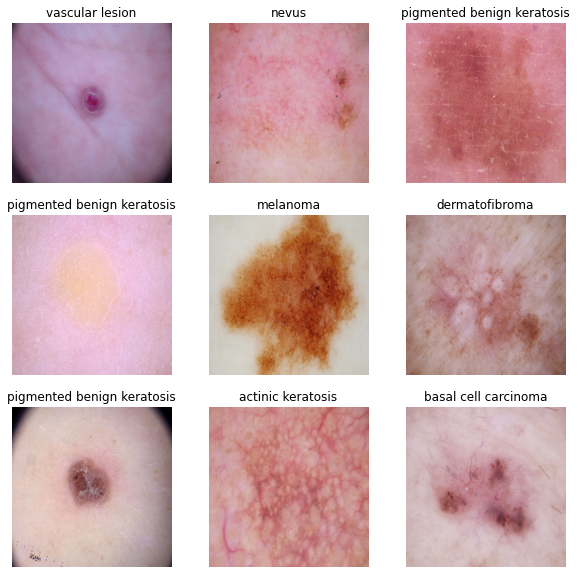

In [ ]:
# Let us plot by using training data to visualize
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

<font color="red">From the above plot we observe an issue that not all the 9 images maybe from disctinct class, as some images could get repeated, hence let us try rectify this by using the list '<b>class_images</b>' that we created earlier containg reference of images from each distinct class.</font>

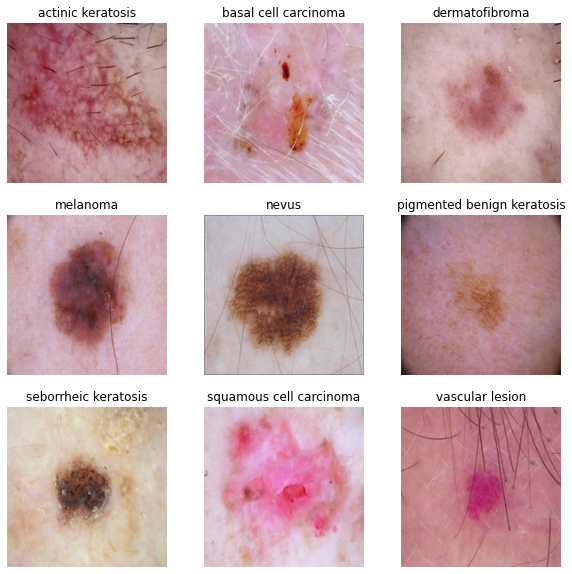

In [ ]:
# Let us again plot one image each from the 9 different classes.
plt.figure(figsize=(10, 10))
for i in range(9):
    img = PIL.Image.open(class_images[i]).resize((img_width, img_height), PIL.Image.ANTIALIAS)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow((np.array(img).astype("uint8")))
    plt.title(class_names[i])
    plt.axis("off")

In [ ]:
# Get the shape of image batch and labels batch
for image_batch, labels_batch in train_ds:
    print("The shape of image_batch is :{0}".format(image_batch.shape))
    print("The shape of labels_batch is :{0}".format(labels_batch.shape))
    break

The shape of image_batch is :(32, 180, 180, 3)
The shape of labels_batch is :(32,)


The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [ ]:
# Let us create the pipeline for prefetching, caching and shuffling the datsets for performance
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
<font style='font-size:14px'>Now let us create a CNN model, which can accurately detect 9 classes present in the dataset.  We will use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network hence it will be good to standardize values to be in the `[0, 1]`</font>

Let us first have a look to understand how normalization would impact the image pixel range which is originally in the range of 0 to 255. After normalizing it should be scaled to the range of 0 to 1.

In [ ]:
# Create variable to hold the refrence of normalized layer
normalization_layer = layers.Rescaling(1./255)

In [ ]:
# We create a normalized dataset and test one of its image sample 
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.009313726 0.98578393


Hence we observed image data was normalized in the above output. Hence we can now apply normalization when creating our model. Please note that we can apply the normalization using the above normalization layer that we created or the second approcah can be to use normalization layer from within the model itself. Hence we will use this second approach.

In [ ]:
# Create the model
num_classes = 9

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, activation='softmax' )
])

### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [ ]:
# Let us compile the model using 'adam' optimizer and loss function as 'SparseCategoricalCrossentropy'
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [ ]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

### Train the model

In [ ]:
# Let us train the model over 20 epochs
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 9s 110ms/step - loss: 2.0340 - accuracy: 0.2461 - val_loss: 1.7346 - val_accuracy: 0.3781
Epoch 2/20
56/56 [==============================] - 2s 42ms/step - loss: 1.7083 - accuracy: 0.3951 - val_loss: 1.6394 - val_accuracy: 0.4228
Epoch 3/20
56/56 [==============================] - 2s 42ms/step - loss: 1.4913 - accuracy: 0.4771 - val_loss: 1.5264 - val_accuracy: 0.4676
Epoch 4/20
56/56 [==============================] - 2s 42ms/step - loss: 1.3126 - accuracy: 0.5301 - val_loss: 1.4059 - val_accuracy: 0.5213
Epoch 5/20
56/56 [==============================] - 2s 42ms/step - loss: 1.2369 - accuracy: 0.5681 - val_loss: 1.3703 - val_accuracy: 0.5369
Epoch 6/20
56/56 [==============================] - 2s 42ms/step - loss: 1.1834 - accuracy: 0.5859 - val_loss: 1.4027 - val_accuracy: 0.4810
Epoch 7/20
56/56 [==============================] - 2s 44ms/step - loss: 1.1440 - accuracy: 0.5854 - val_loss: 1.3567 - val_accuracy: 0.5414
Epoch 8/20
5

### Visualizing training results

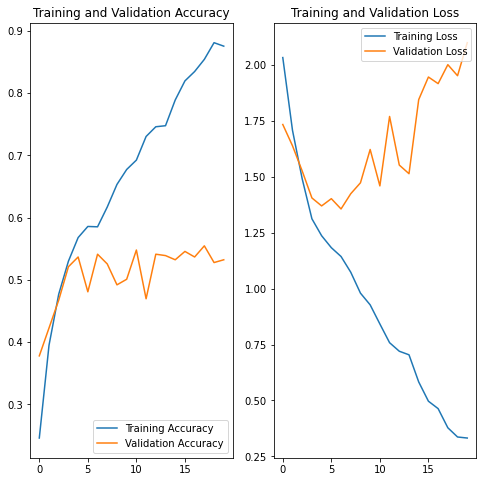

In [ ]:
# Let us create 2 plots for visualizing accuracy and loss between training and validation set 
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### From the graph above we observe that with the increase in epochs, the validation accuracy is much lower than the training accuracy. Also there is a difference in loss which keeps increasing for validation while decreasing for training.
<font style='color:red;font-size:16px'>These are clearly an indication of overfitting.</font>

#### Since we have a model overfit history overfit, hence let us perform some data augumentation where we have augmented samples that are horizontal flipped, rotated and zoomed version of the original image classes. 

In [ ]:
# Perform data augmentation with the choosen augmentation parameters
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

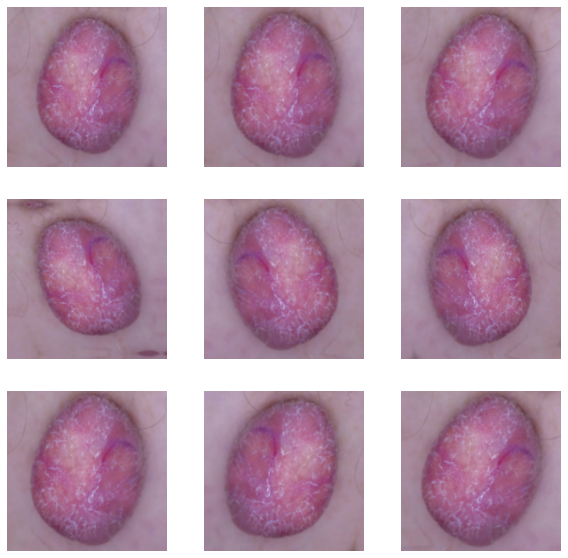

In [ ]:
# Let us visualize some of the augmented samples
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

### Create the model, compile and train the model


#### Let us use Dropout layer as we already observe overfitting in our previous findings

In [ ]:
# Let us create the model with Data augmentation and droput
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, activation='softmax')
])

### Compiling the model

In [ ]:
## Let us compile the model with 'adam' optimizer and 'SparseCategoricalCrossentropy' loss function
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

### Training the model

In [ ]:
## Let us train the updated modelonce again over the same 20 epochs
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 4s 54ms/step - loss: 2.1208 - accuracy: 0.2238 - val_loss: 1.9997 - val_accuracy: 0.2819
Epoch 2/20
56/56 [==============================] - 3s 48ms/step - loss: 1.9156 - accuracy: 0.2946 - val_loss: 1.8658 - val_accuracy: 0.3087
Epoch 3/20
56/56 [==============================] - 3s 51ms/step - loss: 1.7487 - accuracy: 0.3599 - val_loss: 1.6380 - val_accuracy: 0.3915
Epoch 4/20
56/56 [==============================] - 3s 48ms/step - loss: 1.5872 - accuracy: 0.4325 - val_loss: 1.5521 - val_accuracy: 0.4609
Epoch 5/20
56/56 [==============================] - 3s 48ms/step - loss: 1.4966 - accuracy: 0.4632 - val_loss: 1.4965 - val_accuracy: 0.4609
Epoch 6/20
56/56 [==============================] - 3s 48ms/step - loss: 1.4175 - accuracy: 0.4888 - val_loss: 1.4495 - val_accuracy: 0.5034
Epoch 7/20
56/56 [==============================] - 3s 48ms/step - loss: 1.3437 - accuracy: 0.5257 - val_loss: 1.4065 - val_accuracy: 0.4966
Epoch 8/20
56

### Visualizing the results

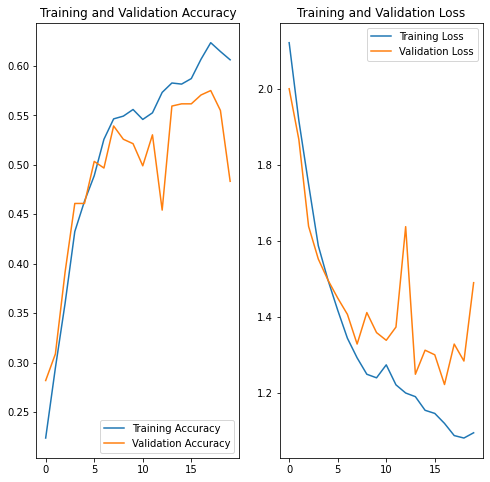

In [ ]:
# Let us create 2 plots for visualizing accuracy and loss between training and validation set 
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

<font style="color:green;font-size:16px"> From the above result we now observe that the overfitting issue has been resolved to a greater extent, but still we find that the accuracy value is still very low with approx 61% for training accuracy and 57% for validation accuracy. Hence we would need to further fine tune the model for even better accuracy.</font>

#### Let us also find the distribution of classes in the training dataset to check for class imbalance, as class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [ ]:
# Create a list to store all the pathsof the augmented images
path_list = [x for x in glob(os.path.join(data_dir_train, '*', '*.jpg'))]
path_list

['/content/gdrive/MyDrive/data/Train/basal cell carcinoma/ISIC_0024504.jpg',
 '/content/gdrive/MyDrive/data/Train/basal cell carcinoma/ISIC_0024515.jpg',
 '/content/gdrive/MyDrive/data/Train/basal cell carcinoma/ISIC_0024550.jpg',
 '/content/gdrive/MyDrive/data/Train/basal cell carcinoma/ISIC_0024572.jpg',
 '/content/gdrive/MyDrive/data/Train/basal cell carcinoma/ISIC_0024564.jpg',
 '/content/gdrive/MyDrive/data/Train/basal cell carcinoma/ISIC_0024573.jpg',
 '/content/gdrive/MyDrive/data/Train/basal cell carcinoma/ISIC_0024582.jpg',
 '/content/gdrive/MyDrive/data/Train/basal cell carcinoma/ISIC_0024590.jpg',
 '/content/gdrive/MyDrive/data/Train/basal cell carcinoma/ISIC_0024595.jpg',
 '/content/gdrive/MyDrive/data/Train/basal cell carcinoma/ISIC_0024632.jpg',
 '/content/gdrive/MyDrive/data/Train/basal cell carcinoma/ISIC_0024634.jpg',
 '/content/gdrive/MyDrive/data/Train/basal cell carcinoma/ISIC_0024665.jpg',
 '/content/gdrive/MyDrive/data/Train/basal cell carcinoma/ISIC_0024666.jpg',

In [ ]:
# Create a list to store the base directory names
lesion_list = [os.path.basename(os.path.dirname(y)) for y in path_list]
lesion_list

['basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',


In [ ]:
# Create a dictionary object combining the path_list and lesion_list
dataframe_dict = dict(zip(path_list, lesion_list))

In [ ]:
# Create a dataframe from the dictionary object
original_df = pd.DataFrame(list(dataframe_dict.items()),columns = ['Path','Label'])

In [ ]:
# Let us check the value counts of each class
original_df['Label'].value_counts()

pigmented benign keratosis    462
melanoma                      438
basal cell carcinoma          376
nevus                         357
squamous cell carcinoma       181
vascular lesion               139
actinic keratosis             114
dermatofibroma                 95
seborrheic keratosis           77
Name: Label, dtype: int64

In [ ]:
# let us create a dataframe from the value counts of the original_df dataframe to be used for plots
nine_classes = pd.DataFrame(original_df['Label'].value_counts().sort_values(ascending=False)).reset_index()

In [ ]:
# Let us calculate the value of counts of each class in percentage to be used for pie chart
class_stats = (nine_classes['Label']/len(original_df))*100

#### Let us plot the distribution of the classes

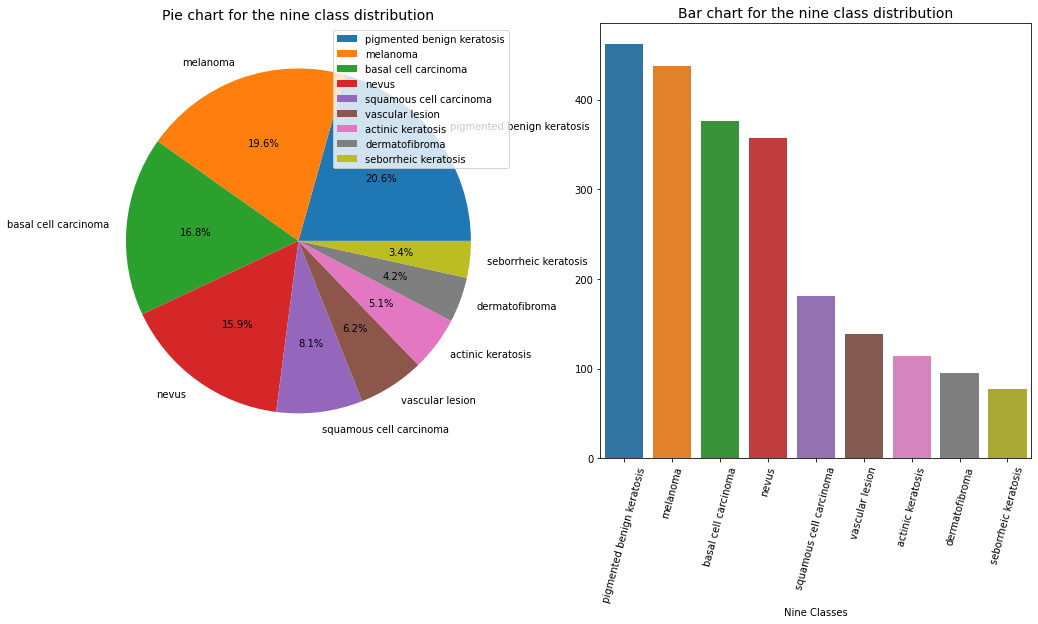

In [ ]:
# Plot a pie chart for the 9 classes and a bar chart for the 9 classes
plt.figure(figsize = (17, 8))
plt.subplot(1,2,1)
ax = class_stats.plot.pie(autopct='%.1f%%', labels=nine_classes['index'], fontsize=10)     
ax.set_ylabel("")
ax.set_title('Pie chart for the nine class distribution',fontsize = 14)
plt.legend()
plt.subplot(1,2,2)
sns.barplot(x = "index",
            y = nine_classes.Label,
            data = nine_classes )
plt.xticks(rotation=75)
plt.xlabel("Nine Classes")
plt.ylabel("")
plt.title('Bar chart for the nine class distribution', fontsize = 14)
plt.show()

#### From the above plots we observe the following:

- The class that has the least number of samples: <font style="color:green;font-size:16px">Seborrheic keratosis</font>
- The classes dominate the data in terms proportionate number of samples: <font style="color:green;font-size:16px">Pigmented benign keratosis, Melanoma, Basal cell carcinoma and Nevus.</font>

### Let us now rectify the class imbalance

For rectification of class imbalance we will use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples and hence no sparsity.<br/><br/>
We will first need to install the Augmentor using the command <b>!pip install Augmentor</b>

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [ ]:
#!pip install Augmentor

In [ ]:
# We define the path to train datset, instantiate a pipeline and execute the Augmentor to add 500 samples per class
path_to_training_dataset="/content/gdrive/MyDrive/data/Train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500)

Initialised with 114 image(s) found.
Output directory set to /content/gdrive/MyDrive/data/Train/actinic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FF784C08A90>: 100%|██████████| 500/500 [00:21<00:00, 23.65 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/gdrive/MyDrive/data/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FF784BBF810>: 100%|██████████| 500/500 [00:21<00:00, 22.85 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/gdrive/MyDrive/data/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FF784F99290>: 100%|██████████| 500/500 [00:22<00:00, 22.02 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/gdrive/MyDrive/data/Train/melanoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x7FF784C22290>: 100%|██████████| 500/500 [01:43<00:00,  4.84 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/gdrive/MyDrive/data/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=767x576 at 0x7FF784C1C890>: 100%|██████████| 500/500 [01:36<00:00,  5.19 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/gdrive/MyDrive/data/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FF7F156E910>: 100%|██████████| 500/500 [00:22<00:00, 22.30 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/gdrive/MyDrive/data/Train/seborrheic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x7FF7F13AF190>: 100%|██████████| 500/500 [00:48<00:00, 10.21 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/gdrive/MyDrive/data/Train/squamous cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FF7F158B3D0>: 100%|██████████| 500/500 [00:20<00:00, 23.87 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/gdrive/MyDrive/data/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FF7F002DCD0>: 100%|██████████| 500/500 [00:22<00:00, 22.72 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [ ]:
# Check the count of the total augmented images (9 classes * 500 samples per class)
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [ ]:
# Create a list to store all the pathsof the augmented images
path_list_new = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
#path_list_new

In [ ]:
# Create a list to store the base directory names
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
#lesion_list_new

In [ ]:
# Create the new dictionary by combining path_list_new and lesion_list_new
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

In [ ]:
# Create a dataframe from the dictionary
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])

In [ ]:
# Check the value counts of the augmented images
df2['Label'].value_counts()

actinic keratosis             500
seborrheic keratosis          500
squamous cell carcinoma       500
vascular lesion               500
dermatofibroma                500
nevus                         500
basal cell carcinoma          500
pigmented benign keratosis    500
melanoma                      500
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images if required to improve training process.

In [ ]:
# Create a new dataframe by combining the previous dataframe and the new dataframe
new_df = original_df.append(df2)

In [ ]:
# Let us now check the new dataframe value counts with appended dataframes
new_df['Label'].value_counts()

pigmented benign keratosis    962
melanoma                      938
basal cell carcinoma          876
nevus                         857
squamous cell carcinoma       681
vascular lesion               639
actinic keratosis             614
dermatofibroma                595
seborrheic keratosis          577
Name: Label, dtype: int64

### Let us recheck the class imbalance by plotting the graphs for visualization

In [ ]:
# let us create a dataframe from the value counts of the new_df dataframe to be used for plots
nine_classes = pd.DataFrame(new_df['Label'].value_counts().sort_values(ascending=False)).reset_index()

In [ ]:
# Let us calculate the value of counts of each class in percentage to be used for pie chart
class_stats = (nine_classes['Label']/len(new_df))*100

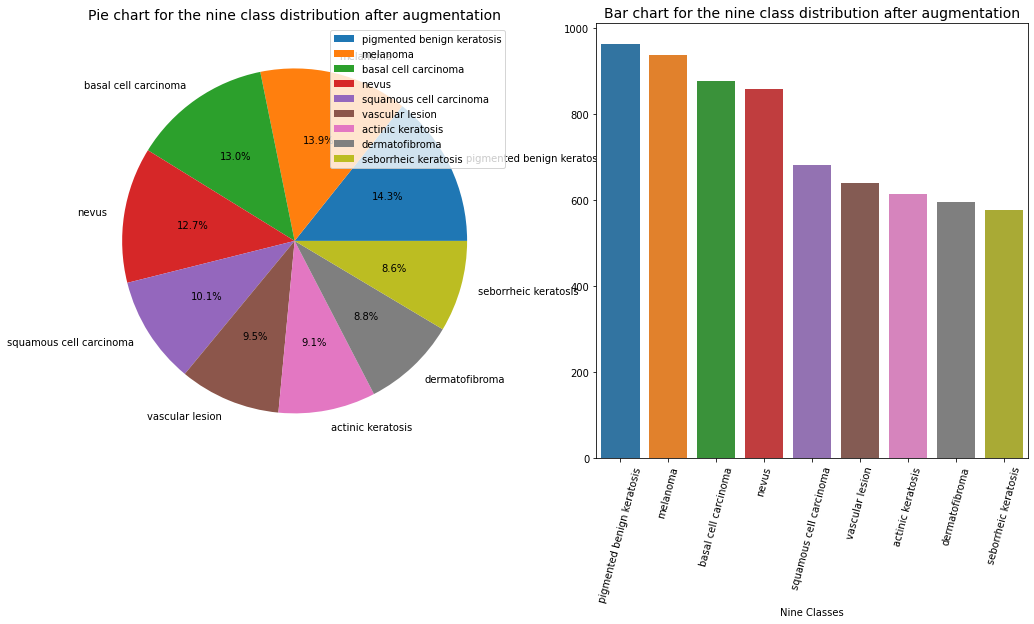

In [ ]:
# Plot a pie chart for the 9 classes and a bar chart for the 9 classes
plt.figure(figsize = (17, 8))
plt.subplot(1,2,1)
ax = class_stats.plot.pie(autopct='%.1f%%', labels=nine_classes['index'], fontsize=10)     
ax.set_ylabel("")
ax.set_title('Pie chart for the nine class distribution after augmentation',fontsize = 14)
plt.legend()
plt.subplot(1,2,2)
sns.barplot(x = "index",
            y = nine_classes.Label,
            data = nine_classes )
plt.xticks(rotation=75)
plt.xlabel("Nine Classes")
plt.ylabel("")
plt.title('Bar chart for the nine class distribution after augmentation', fontsize = 14)
plt.show()

<font style="color:green;font-size:16px">From the above graph we now observe that the class imbalance is now much improved.</font>

#### Train the model on the data created using Augmentor

In [ ]:
# Define the batch size, image height and image width
batch_size = 32
img_height = 180
img_width = 180

#### Create a training dataset

In [ ]:
# Create the training dataset with 20% validation set and 80% training set
data_dir_train= path_to_training_dataset# +"output"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "training",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### Create a validation dataset

In [ ]:
# Create the validation dataset with 20% validation set and 80% training set
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "validation",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### Create the model (including normalization)

In [ ]:
## Create the model including normalization
model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, activation='softmax')
])

#### Compile the model

In [ ]:
## Let us compile the model (with optimizer as 'adam' and loss function as 'SparseCategoricalCrossentropy'
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

#### Train the model

In [ ]:
# Let us train the model over 30 epochs now
epochs = 30
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
169/169 [==============================] - 42s 234ms/step - loss: 2.0619 - accuracy: 0.2326 - val_loss: 1.6370 - val_accuracy: 0.3593
Epoch 2/30
169/169 [==============================] - 40s 231ms/step - loss: 1.4553 - accuracy: 0.4540 - val_loss: 1.3404 - val_accuracy: 0.5256
Epoch 3/30
169/169 [==============================] - 39s 225ms/step - loss: 1.2509 - accuracy: 0.5388 - val_loss: 1.2383 - val_accuracy: 0.5561
Epoch 4/30
169/169 [==============================] - 40s 229ms/step - loss: 1.0684 - accuracy: 0.6150 - val_loss: 1.0707 - val_accuracy: 0.6147
Epoch 5/30
169/169 [==============================] - 40s 229ms/step - loss: 0.9520 - accuracy: 0.6526 - val_loss: 1.1908 - val_accuracy: 0.5872
Epoch 6/30
169/169 [==============================] - 39s 223ms/step - loss: 0.7869 - accuracy: 0.7168 - val_loss: 0.9809 - val_accuracy: 0.6511
Epoch 7/30
169/169 [==============================] - 38s 219ms/step - loss: 0.6792 - accuracy: 0.7557 - val_loss: 0.8613 - val_ac

#### Visualize the model results

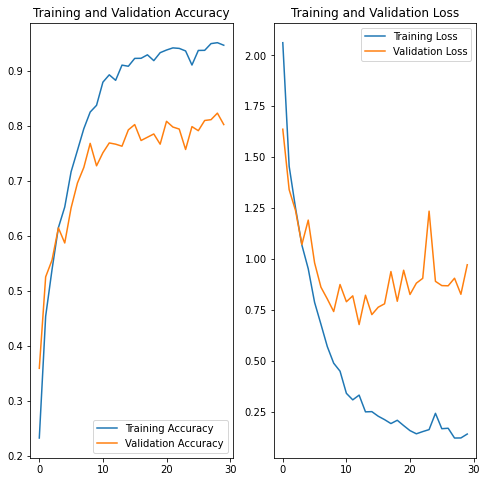

In [ ]:
# Let us create 2 plots for visualizing accuracy and loss between training and validation set
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?



<font style="color:green;font-size:14px">From the above result we observe that the accuracy improved after the class rebalance, but we still find a good amount of difference between training and validation accuracy. hence let us try to augment again with 500 more images per sample each, making it 1000 augmented samples per class and rebuild and retrain the model once again to check.</font>

In [ ]:
# Apply augmentation once again with additional 500 samples
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500)

Initialised with 114 image(s) found.
Output directory set to /content/gdrive/MyDrive/data/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FF7F0C12F90>: 100%|██████████| 500/500 [00:20<00:00, 24.34 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/gdrive/MyDrive/data/Train/basal cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FF7F193C290>: 100%|██████████| 500/500 [00:21<00:00, 23.40 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/gdrive/MyDrive/data/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FF7F18EE250>: 100%|██████████| 500/500 [00:21<00:00, 23.17 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/gdrive/MyDrive/data/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7FF7F190B790>: 100%|██████████| 500/500 [01:33<00:00,  5.34 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/gdrive/MyDrive/data/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=1504x1129 at 0x7FF7FF95F0D0>: 100%|██████████| 500/500 [01:33<00:00,  5.34 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/gdrive/MyDrive/data/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FF7F18CEFD0>: 100%|██████████| 500/500 [00:20<00:00, 24.58 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/gdrive/MyDrive/data/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7FF7F17B7A10>: 100%|██████████| 500/500 [00:46<00:00, 10.85 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/gdrive/MyDrive/data/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FF784BF6A10>: 100%|██████████| 500/500 [00:20<00:00, 24.44 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/gdrive/MyDrive/data/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FF7F1637FD0>: 100%|██████████| 500/500 [00:20<00:00, 24.26 Samples/s]


#### Create a training dataset

In [ ]:
# Create the training dataset with 20% validation set and 80% training set
data_dir_train= path_to_training_dataset# +"output"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "training",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 11239 files belonging to 9 classes.
Using 8992 files for training.


#### Create a validation dataset

In [ ]:
# Create the validation dataset with 20% validation set and 80% training set
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "validation",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 11239 files belonging to 9 classes.
Using 2247 files for validation.


#### Create the model (including normalization)

In [ ]:
## Create the model including normalization
model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, activation='softmax')
])

#### Compile the model

In [ ]:
## Let us compile the model (with optimizer as 'adam' and loss function as 'SparseCategoricalCrossentropy'
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

#### Train the model

In [ ]:
# Let us train the model over 50 epochs
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
281/281 [==============================] - 62s 215ms/step - loss: 1.6930 - accuracy: 0.3492 - val_loss: 1.3406 - val_accuracy: 0.4993
Epoch 2/30
281/281 [==============================] - 60s 210ms/step - loss: 1.2113 - accuracy: 0.5517 - val_loss: 1.0561 - val_accuracy: 0.6186
Epoch 3/30
281/281 [==============================] - 61s 212ms/step - loss: 0.9746 - accuracy: 0.6422 - val_loss: 0.8842 - val_accuracy: 0.6894
Epoch 4/30
281/281 [==============================] - 65s 229ms/step - loss: 0.7514 - accuracy: 0.7323 - val_loss: 0.6901 - val_accuracy: 0.7695
Epoch 5/30
281/281 [==============================] - 65s 228ms/step - loss: 0.5801 - accuracy: 0.7900 - val_loss: 0.5961 - val_accuracy: 0.7819
Epoch 6/30
281/281 [==============================] - 61s 214ms/step - loss: 0.4447 - accuracy: 0.8430 - val_loss: 0.4691 - val_accuracy: 0.8407
Epoch 7/30
281/281 [==============================] - 65s 227ms/step - loss: 0.3390 - accuracy: 0.8763 - val_loss: 0.5361 - val_ac

#### Visualize the model results

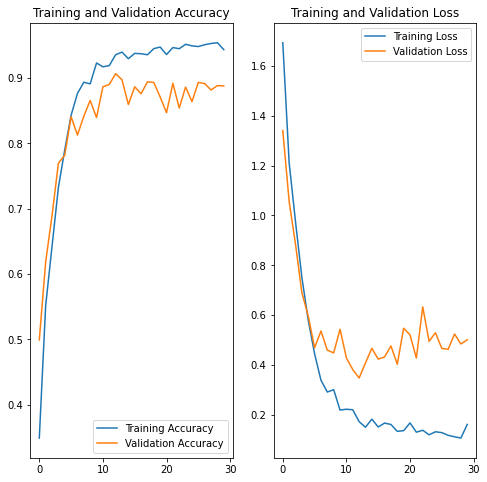

In [ ]:
# Let us create 2 plots for visualizing accuracy and loss between training and validation set
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

<font style="color:green;font-size:20px">Now we observe that there is a good amount of improvement after further data augmentation. The train accuracy is 95% while the validation accuracy is 87% approx. Hence our model has now improved to a greater extent.</font>

<center><font color="#ccc">======================== End of Assignment ======================================</font></center>